In [1]:
%pylab inline
import sys

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import arviz as az

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm

rcParams['font.family'] = 'sans-serif'

sys.path.append('../')
from mederrata_spmf import PoissonMatrixFactorization


Populating the interactive namespace from numpy and matplotlib


In this notebook, we look at the $\mathcal{M}$-open setting, where the generating process is in the span of models.

# Generate a random matrices V, W

For V, assume that 10 variables share a factor structure and the other 20 are noise

In [2]:
N = 50000
D_factor = 10
D_noise = 20
P = 3

V = np.abs(np.random.normal(1.5, 0.5, size=(P,D_factor)))
Z = np.abs(np.random.normal(0.5, size=(N,P)))

ZV = Z.dot(V)

X = np.zeros((N, D_factor+D_noise))
X = np.random.poisson(1.,size=(N,D_noise+D_factor))
X[:, ::3] = np.random.poisson(ZV)

In [3]:
# Test taking in from tf.dataset, don't pre-batch
data = tf.data.Dataset.from_tensor_slices(
    {
        'data': X,
        'indices': np.arange(N),
        'normalization': np.ones(N)
    })

data = data.batch(10000)

In [4]:
# strategy = tf.distribute.MirroredStrategy()
strategy = None
factor = PoissonMatrixFactorization(
    data, latent_dim=P, strategy=strategy,
    encoder_function=lambda x: x, decoder_function=lambda x: x,
    scale_rates=True, 
    dtype=tf.float64)
# Test to make sure sampling works


Feature dim: 30 -> Latent dim 3


In [5]:
losses = factor.calibrate_advi(
    num_epochs=100, learning_rate=.1)




W0520 20:42:45.800009 4669582784 deprecation.py:506] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/resource_variable_ops.py:1786: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Initial loss: 85.23310116614293
Epoch 1: average-batch loss: 71.48663785764526 last batch loss: 59.922405100997096
Saved a checkpoint: ./.tf_ckpts/chkpt-1
Epoch 2: average-batch loss: 58.32883440349336 last batch loss: 53.55654112631157
Saved a checkpoint: ./.tf_ckpts/chkpt-2
Epoch 3: average-batch loss: 51.40198086729738 last batch loss: 50.16862231565317
Saved a checkpoint: ./.tf_ckpts/chkpt-3
Epoch 4: average-batch loss: 48.707534430494036 last batch loss: 48.606143178676284
Saved a checkpoint: ./.tf_ckpts/chkpt-4
Epoch 5: average-batch loss: 48.132776932140345 last batch loss: 48.05937912551121
Saved a checkpoint: ./.tf_ckpts/chkpt-5
Epoch 6: average-batch loss: 48.14973767653457 last batch loss: 48.261019018518255
Epoch 7: average-batch loss: 48.14493666500213 last batch loss: 48.145420583841315
Epoch 8: average-batch loss: 48.160113220421856 last batch loss: 48.059727929970116
We are in a loss plateau learning rate: 0.025 loss: 48.20742270765202
Restoring from a checkpoint - loss

Epoch 68: average-batch loss: 43.35983895041538 last batch loss: 43.31801834881429
Saved a checkpoint: ./.tf_ckpts/chkpt-62
Epoch 69: average-batch loss: 43.32881356143772 last batch loss: 43.323263163933746
Saved a checkpoint: ./.tf_ckpts/chkpt-63
Epoch 70: average-batch loss: 43.28369085480119 last batch loss: 43.27149786461548
Saved a checkpoint: ./.tf_ckpts/chkpt-64
Epoch 71: average-batch loss: 43.26338574216873 last batch loss: 43.315705404179816
Saved a checkpoint: ./.tf_ckpts/chkpt-65
Epoch 72: average-batch loss: 43.2556729361571 last batch loss: 43.237379818804975
Saved a checkpoint: ./.tf_ckpts/chkpt-66
Epoch 73: average-batch loss: 43.222087205945186 last batch loss: 43.158763920046994
Saved a checkpoint: ./.tf_ckpts/chkpt-67
Epoch 74: average-batch loss: 43.18023019042386 last batch loss: 43.13908036487749
Saved a checkpoint: ./.tf_ckpts/chkpt-68
Epoch 75: average-batch loss: 43.14039606708011 last batch loss: 43.1203978364656
Saved a checkpoint: ./.tf_ckpts/chkpt-69
Epoch

In [6]:
waic = factor.waic()
print(waic)

{'waic': 1346653.6377816445, 'se': 1929.8569442303196, 'lppd': -465265.7102429704, 'pwaic': 208061.10864785186}


In [7]:
surrogate_samples = factor.surrogate_distribution.sample(1000)
weights = surrogate_samples['s']/tf.reduce_sum(surrogate_samples['s'],-2,keepdims=True)
intercept_data = az.convert_to_inference_data(
    {
        r"$w_d$": 
            (tf.squeeze(surrogate_samples['w'])*weights[:,-1,:]*factor.norm_factor).numpy().T})

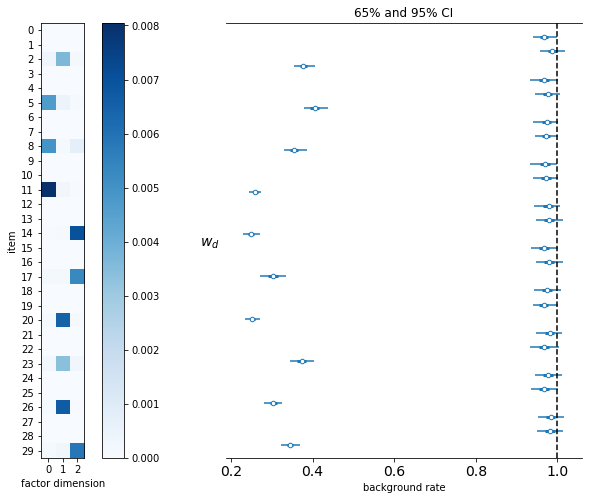

In [8]:
fig, ax = plt.subplots(1,2, figsize=(14,8))
D = factor.feature_dim
pcm = ax[0].imshow(factor.encoding_matrix().numpy()[::-1,:], vmin=0, cmap="Blues")
ax[0].set_yticks(np.arange(D))
ax[0].set_yticklabels(np.arange(D))
ax[0].set_ylabel("item")
ax[0].set_xlabel("factor dimension")
ax[0].set_xticks(np.arange(P))
ax[0].set_xticklabels(np.arange(P))

fig.colorbar(pcm, ax=ax[0], orientation = "vertical")
az.plot_forest(intercept_data, ax=ax[1])
ax[1].set_xlabel("background rate")
ax[1].set_ylim((-0.014,.466))
ax[1].set_title("65% and 95% CI")
ax[1].axvline(1.0, linestyle='dashed', color="black")
plt.savefig('mix_factorization_sepmf.pdf', bbox_inches='tight')
plt.show()


In [9]:
factor.calibrated_expectations['s']/tf.reduce_sum(factor.calibrated_expectations['s'], axis=0, keepdims=True)

<tf.Tensor: shape=(2, 30), dtype=float64, numpy=
array([[0.79489666, 0.1680557 , 0.16585526, 0.79675315, 0.16835621,
        0.16609785, 0.746308  , 0.16894922, 0.16558792, 0.80913185,
        0.16909576, 0.16518475, 0.77551956, 0.16813163, 0.16908941,
        0.83556481, 0.16510326, 0.16575929, 0.82225034, 0.16992351,
        0.16869104, 0.79103365, 0.17229528, 0.16363717, 0.75382932,
        0.16387975, 0.17020127, 0.73510877, 0.16828278, 0.1687178 ],
       [0.20510334, 0.8319443 , 0.83414474, 0.20324685, 0.83164379,
        0.83390215, 0.253692  , 0.83105078, 0.83441208, 0.19086815,
        0.83090424, 0.83481525, 0.22448044, 0.83186837, 0.83091059,
        0.16443519, 0.83489674, 0.83424071, 0.17774966, 0.83007649,
        0.83130896, 0.20896635, 0.82770472, 0.83636283, 0.24617068,
        0.83612025, 0.82979873, 0.26489123, 0.83171722, 0.8312822 ]])>